# Alignment algorithm

This notebook explains the details on the Viterbi alignment procedure using the Huggingface Transformers library. The goal of the algorithm is to match a word sequence to recorded speech.

In [53]:
from typing import Tuple, List

import numpy as np
import torchaudio
from IPython.display import Audio
from matplotlib.patches import Rectangle
from matplotlib.pyplot import figure, plot, pcolormesh, yticks, scatter, subplots, xlabel
from transformers import Wav2Vec2Processor, AutoModelForCTC

We start by loading a speech model.

In [3]:
w2v2_model = 'asr_model'
processor = Wav2Vec2Processor.from_pretrained(str(w2v2_model))
model = AutoModelForCTC.from_pretrained(str(w2v2_model)).cuda()

We will use a specific short piece of audio from a pre-determined location in our file.

In [15]:
audio = torchaudio.load('data/0XpZGGwDkN8.wav')[0].squeeze().numpy()[16146911:16292191]

Audio(audio, rate=16000)

This is what the audio looks like in graphical form.

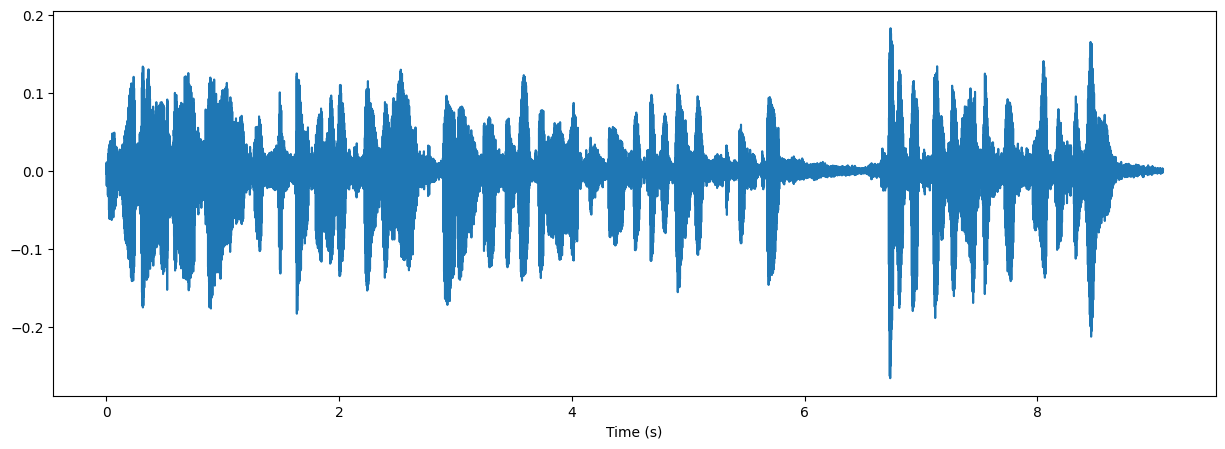

In [54]:
figure(figsize=(15, 5))
t = np.linspace(0, audio.size / 16000, audio.size)
plot(t, audio)
_ = xlabel('Time (s)')

This particular piece of audio has the following transcription.

In [10]:
trans = 'wznawiam obrady i przystąpimy do stwierdzenia kworum proszę zatem o naciśnięcie jakiegokolwiek przycisku w celu potwierdzenia obecności na posiedzeniu'

We can use the loaded processor to analyze the transcription and convert it to a list of labels.

In [11]:
labels = processor(text=trans).input_ids

The output of this procedure is a sequence of integers.

In [13]:
print(labels)

[34, 37, 22, 5, 34, 16, 5, 21, 4, 24, 7, 28, 5, 10, 36, 4, 16, 4, 26, 28, 37, 36, 29, 31, 6, 26, 16, 21, 36, 4, 10, 24, 4, 29, 31, 34, 16, 11, 28, 10, 37, 11, 22, 16, 5, 4, 18, 34, 24, 28, 32, 21, 4, 26, 28, 24, 29, 37, 12, 4, 37, 5, 31, 11, 21, 4, 24, 4, 22, 5, 8, 16, 30, 22, 16, 12, 8, 16, 11, 4, 17, 5, 18, 16, 11, 14, 24, 18, 24, 19, 34, 16, 11, 18, 4, 26, 28, 37, 36, 8, 16, 29, 18, 32, 4, 34, 4, 8, 11, 19, 32, 4, 26, 24, 31, 34, 16, 11, 28, 10, 37, 11, 22, 16, 5, 4, 24, 7, 11, 8, 22, 24, 30, 8, 16, 4, 22, 5, 4, 26, 24, 29, 16, 11, 10, 37, 11, 22, 16, 32]


To decode their meaning, we need to use the tokenizer vocabulary.

In [12]:
vocab = processor.tokenizer.get_vocab()
rvocab = {v: k for k, v in vocab.items()}

Once decoded, we can observe that the individual tokens are simply letters of the words above. Words are delimited by a special token '|'.

In [14]:
print([rvocab[l] for l in labels])

['w', 'z', 'n', 'a', 'w', 'i', 'a', 'm', '|', 'o', 'b', 'r', 'a', 'd', 'y', '|', 'i', '|', 'p', 'r', 'z', 'y', 's', 't', 'ą', 'p', 'i', 'm', 'y', '|', 'd', 'o', '|', 's', 't', 'w', 'i', 'e', 'r', 'd', 'z', 'e', 'n', 'i', 'a', '|', 'k', 'w', 'o', 'r', 'u', 'm', '|', 'p', 'r', 'o', 's', 'z', 'ę', '|', 'z', 'a', 't', 'e', 'm', '|', 'o', '|', 'n', 'a', 'c', 'i', 'ś', 'n', 'i', 'ę', 'c', 'i', 'e', '|', 'j', 'a', 'k', 'i', 'e', 'g', 'o', 'k', 'o', 'l', 'w', 'i', 'e', 'k', '|', 'p', 'r', 'z', 'y', 'c', 'i', 's', 'k', 'u', '|', 'w', '|', 'c', 'e', 'l', 'u', '|', 'p', 'o', 't', 'w', 'i', 'e', 'r', 'd', 'z', 'e', 'n', 'i', 'a', '|', 'o', 'b', 'e', 'c', 'n', 'o', 'ś', 'c', 'i', '|', 'n', 'a', '|', 'p', 'o', 's', 'i', 'e', 'd', 'z', 'e', 'n', 'i', 'u']


Apart from processing the text, we also need to process the audio. In case of wav2vec2 models, the feature extractor simply copies the audio and adds an attention mask which is just a bunch of 1s, the same length as the audio.

In [17]:
processed = processor.feature_extractor(audio, sampling_rate=16000, return_tensors="pt")
processed

{'input_values': tensor([[-0.0983, -0.0416, -0.0035,  ...,  0.0603,  0.0648,  0.0479]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}

Now we can use the model to compute to log-likelihoods of the individual tokens (from the vocabulary) in time. This is done on the GPU and later copied back to CPU and converted to a numpy array.

In [18]:
import torch

with torch.no_grad():
    logits = model(input_values=processed['input_values'].cuda(),
                   attention_mask=processed['attention_mask'].cuda()).logits.cpu().numpy().squeeze()

Unlike the audio (which is ~9 seconds long), the log-likelihood matrix is based on a windowed representation of the audio. Each column of the matrix represents a roughly 20 ms frame of audio. The dimension of size 40 represents the individual tokens in the vocabulary.

In [19]:
logits.shape

(453, 40)

We can draw the map on screen and observe that it recognizes the individual spoken letters just fine. Note that it also recognizes the locations of the word delimiter at word boundaries. Also note the activation of the pad token being present almost everywhere. The pad token can be chosen in almost every moment to sort of "bridge-the-gap" between consecutive tokens.

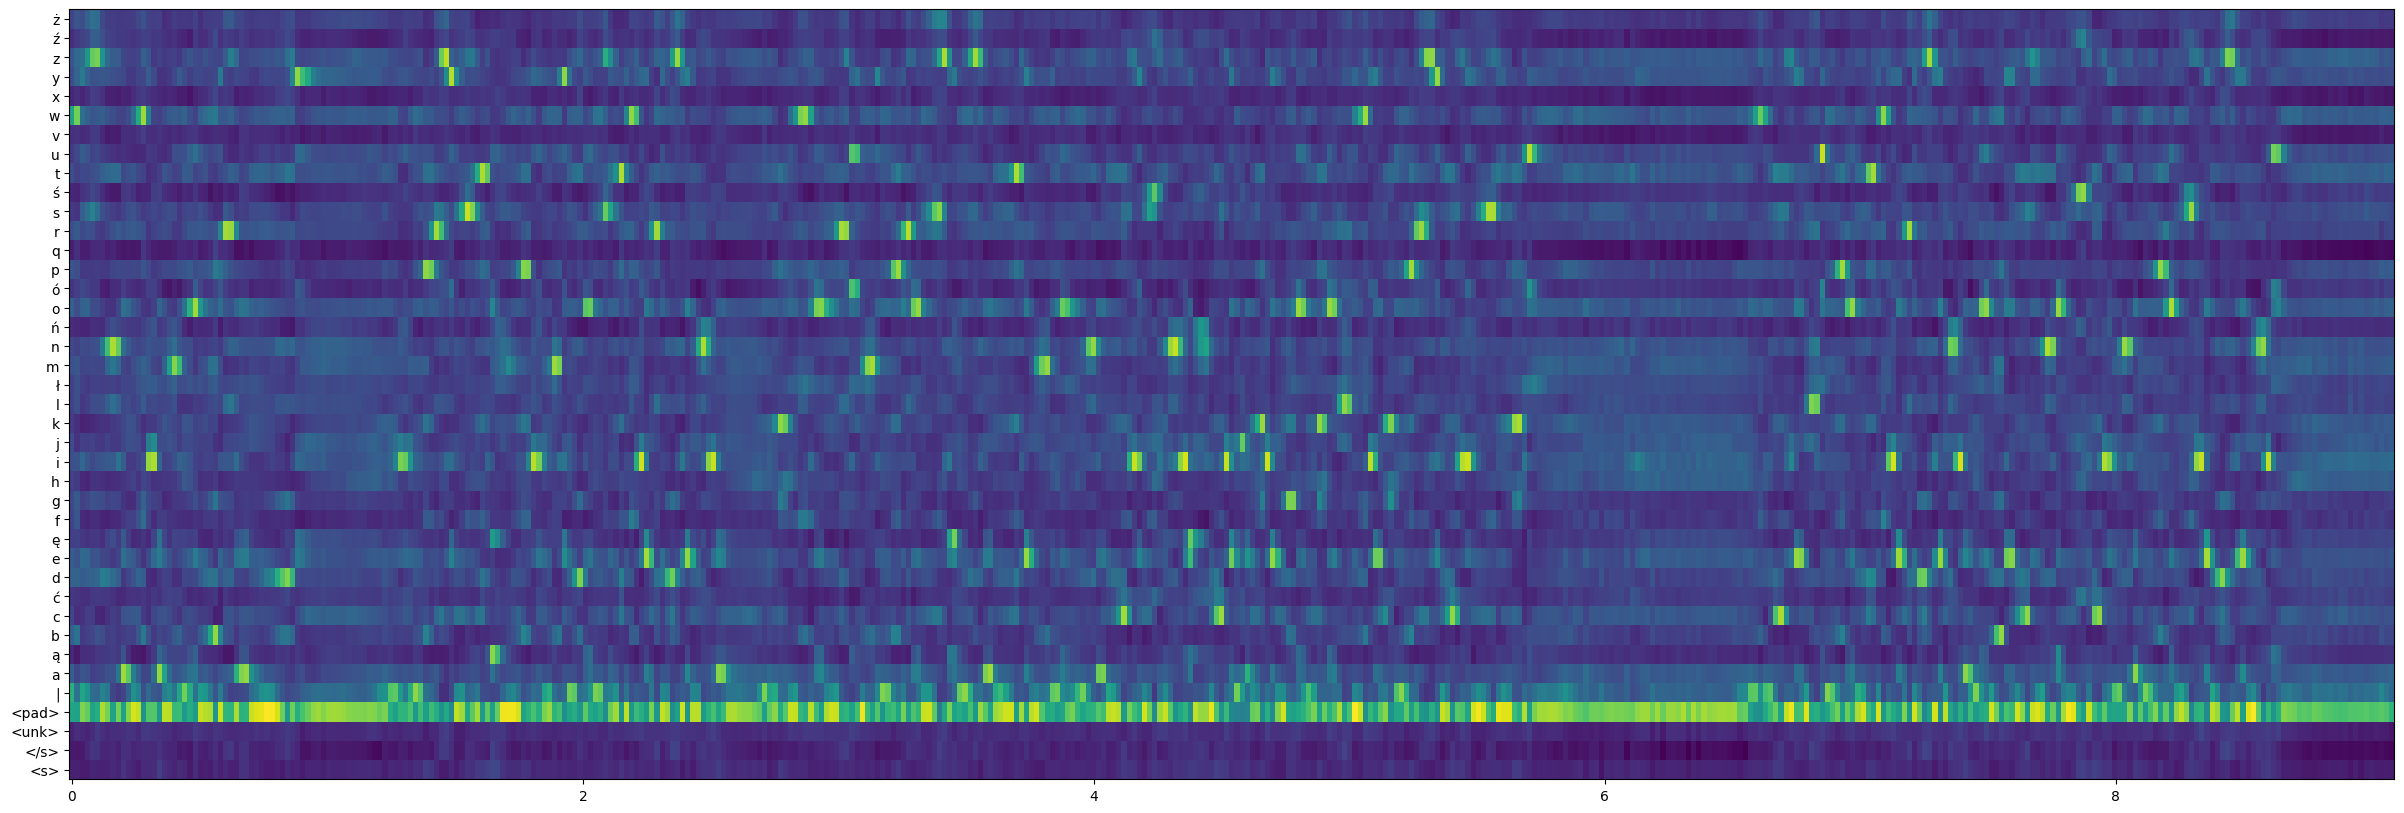

In [26]:
figure(figsize=(30, 10))

t = np.linspace(0, audio.size / 16000, logits.shape[0])
l = np.arange(logits.shape[1])

pcolormesh(t, l, logits.T)
_ = yticks(np.array(list(vocab.values())), list(vocab.keys()))

Our goal is to find a path along this sequence of tokens that decodes the text above, but also that the path has a maximum sum of likelihood values that it traversed along the way. It should be apparent that there is a large amount of different paths available. In fact, the way to solve this is to construct a datastructure known as the trellis, which is a graph that represents all the possible paths and then simply create an algorithm which finds the one with the best likelihood.

The Viterbi algorithm implemented below is based on the paper: Rabiner, Lawrence R. "A tutorial on hidden Markov models and selected applications in speech recognition." Proc. IEEE 77 (1989): 257-286.

In [30]:
def viterbi(logits: np.ndarray, labels: np.ndarray, pad_id: int = 0) -> Tuple[List[int], np.ndarray]:
    T = logits.shape[0]
    N = len(labels)
    delta = np.zeros((T, N))
    psi = np.zeros((T, N), dtype=int)

    delta[0, :] = -np.inf
    delta[0, 0] = logits[0][pad_id]

    a = np.zeros((N,))
    b = np.zeros((N,))
    o = np.zeros((N,))
    M = np.arange(N)

    for t in range(1, T):
        delta[t, :] = -np.inf
        beg = np.clip(t - T + N, 0, N - 1)
        end = np.clip(t + 1, 0, N)

        r = np.arange(beg, end)

        a[r] = delta[t - 1][r - 1]
        b[r] = delta[t - 1][r]

        o[r] = logits[t][labels[r]]
        opad = logits[t][pad_id]

        m = np.zeros(N, dtype=bool)
        m[r] = (a > b)[r]
        delta[t][m] = a[m] + o[m]
        psi[t][m] = M[m] - 1

        m = np.zeros(N, dtype=bool)
        m[r] = (a <= b)[r]
        delta[t][m] = b[m] + opad
        psi[t][m] = M[m]

    bestpath = [delta[T - 1].argmax()]
    for t in range(T - 2, -1, -1):
        bestpath.append(psi[t + 1][bestpath[-1]])
    bestpath.reverse()
    return bestpath, delta

To run the algorithm, we use the above label sequence but add a word delimiter token at the start and the end.

In [32]:
lf = (4,) + tuple(labels) + (4,)
bestpath, delta = viterbi(logits, np.array(lf), pad_id=3)

We can draw the forward probabilities of the trellis as color values and use the solid line to represent the best path. The gray areas the locations that cannot be accessed.

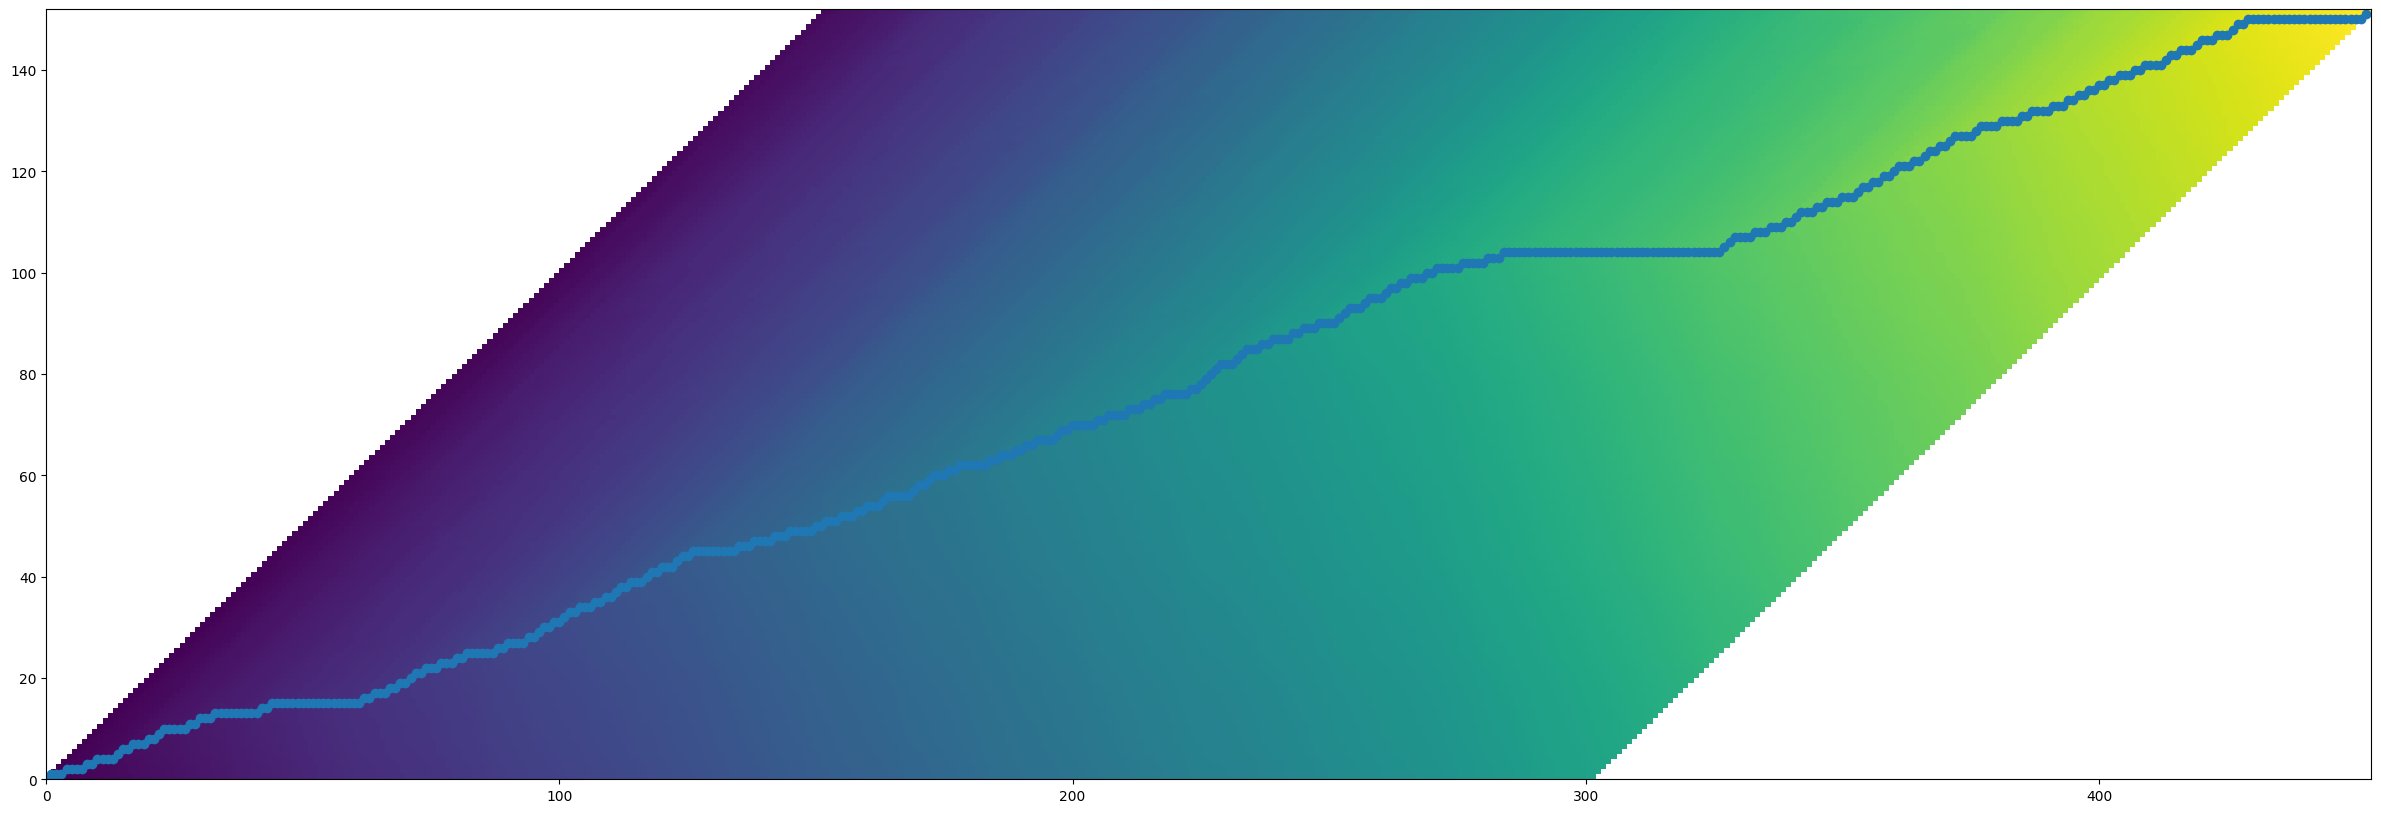

In [33]:
figure(figsize=(30, 10))
pcolormesh(delta.T)
scatter(list(range(logits.shape[0])), bestpath)

To get the word timings, we need to detect the individual word boundary tokens.

In [42]:
def align(logits: np.ndarray, labels: List[int], fr_len: float = 0.02, wl_id: int = 4) -> np.ndarray:
    labels = (wl_id,) + tuple(labels) + (wl_id,)
    bestpath, _ = viterbi(logits, np.array(labels), pad_id=3)

    dur = []
    ls = 0
    for t, p in enumerate(bestpath):
        if labels[p] == wl_id:
            if t > ls:
                dur.append((ls, t))
            ls = t + 1

    return np.array(dur) * fr_len

These are the timings acquired by the above procedure.

In [55]:
word_lens = align(logits, labels)
word_lens

array([[0.02, 0.44],
       [0.46, 1.24],
       [1.28, 1.34],
       [1.38, 1.94],
       [1.98, 2.04],
       [2.08, 2.7 ],
       [2.76, 3.16],
       [3.2 , 3.46],
       [3.52, 3.82],
       [3.86, 3.94],
       [3.96, 4.54],
       [4.56, 5.16],
       [5.22, 6.54],
       [6.56, 6.58],
       [6.66, 6.84],
       [6.9 , 7.42],
       [7.44, 7.96],
       [8.  , 8.08],
       [8.14, 9.04]])

If we superimpose them on the audio, we can verify that they look mostly okay.

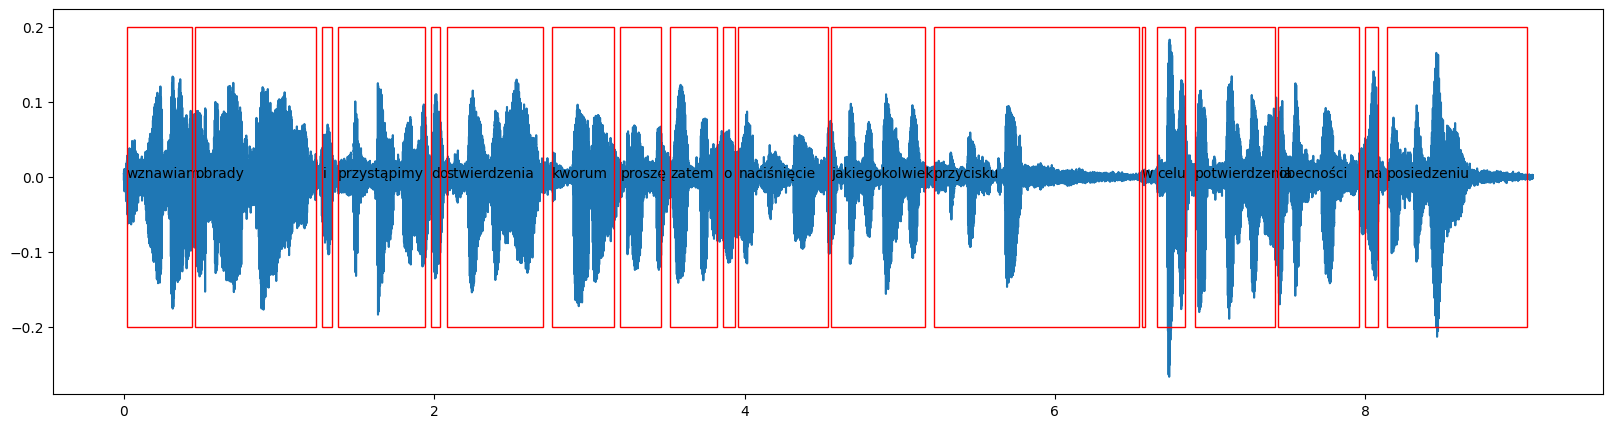

In [48]:
t = np.linspace(0, audio.size / 16000, audio.size)

fig, ax = subplots(figsize=(20, 5))
ax.plot(t, audio)
for w, (b, e) in zip(trans.split(), word_lens):
    ax.annotate(w, (b, 0))
    ax.add_patch(Rectangle((b, 0.2), e - b, -0.4, fill=None, linestyle='-', edgecolor='r', zorder=100))

But to make extra sure, we can extract the audio segment for each individual word and play it back.

In [50]:
Fs = 16000
for w, (b, e) in zip(trans.split(), word_lens):
    seg = audio[int(b * Fs):int(e * Fs)]
    display(w)
    display(Audio(seg, rate=Fs))

'wznawiam'

'obrady'

'i'

'przystąpimy'

'do'

'stwierdzenia'

'kworum'

'proszę'

'zatem'

'o'

'naciśnięcie'

'jakiegokolwiek'

'przycisku'

'w'

'celu'

'potwierdzenia'

'obecności'

'na'

'posiedzeniu'